In [1]:
from sklearn import cluster, datasets, mixture

noisy_moons = datasets.make_moons(n_samples=500, noise=0.11)
# Extracting features and labels
features = noisy_moons[0]
labels = noisy_moons[1]

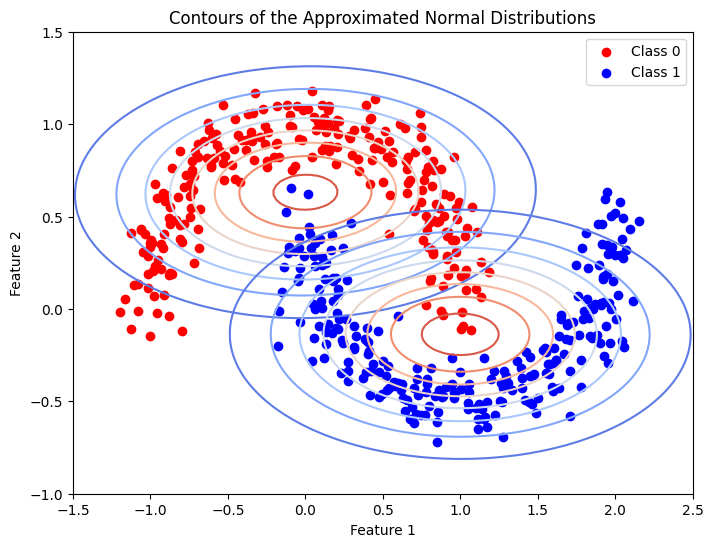

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Separate the dataset into two classes
class_0 = noisy_moons[0][noisy_moons[1] == 0]
class_1 = noisy_moons[0][noisy_moons[1] == 1]

# Calculate mean and covariance for each class
mean_0 = np.mean(class_0, axis=0)
cov_0 = np.cov(class_0, rowvar=False)

mean_1 = np.mean(class_1, axis=0)
cov_1 = np.cov(class_1, rowvar=False)

# Function to calculate the Gaussian density
def gaussian_density(x, mean, cov):
    n = mean.shape[0]
    diff = (x - mean).reshape(-1, 1)
    return np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff)) / \
           ((2 * np.pi)**(n/2) * np.sqrt(np.linalg.det(cov)))

# Creating a grid of points to plot
x, y = np.linspace(-1.5, 2.5, 100), np.linspace(-1, 1.5, 100)
X, Y = np.meshgrid(x, y)
Z0 = np.zeros(X.shape)
Z1 = np.zeros(X.shape)

# Calculating the density for each point in the grid
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z0[i, j] = gaussian_density(np.array([X[i, j], Y[i, j]]), mean_0, cov_0)
        Z1[i, j] = gaussian_density(np.array([X[i, j], Y[i, j]]), mean_1, cov_1)

# Plotting the contours
plt.figure(figsize=(8, 6))
plt.contour(X, Y, Z0, levels=10, cmap='coolwarm')
plt.contour(X, Y, Z1, levels=10, cmap='coolwarm')
plt.scatter(class_0[:, 0], class_0[:, 1], color='red', label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], color='blue', label='Class 1')
plt.title('Contours of the Approximated Normal Distributions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


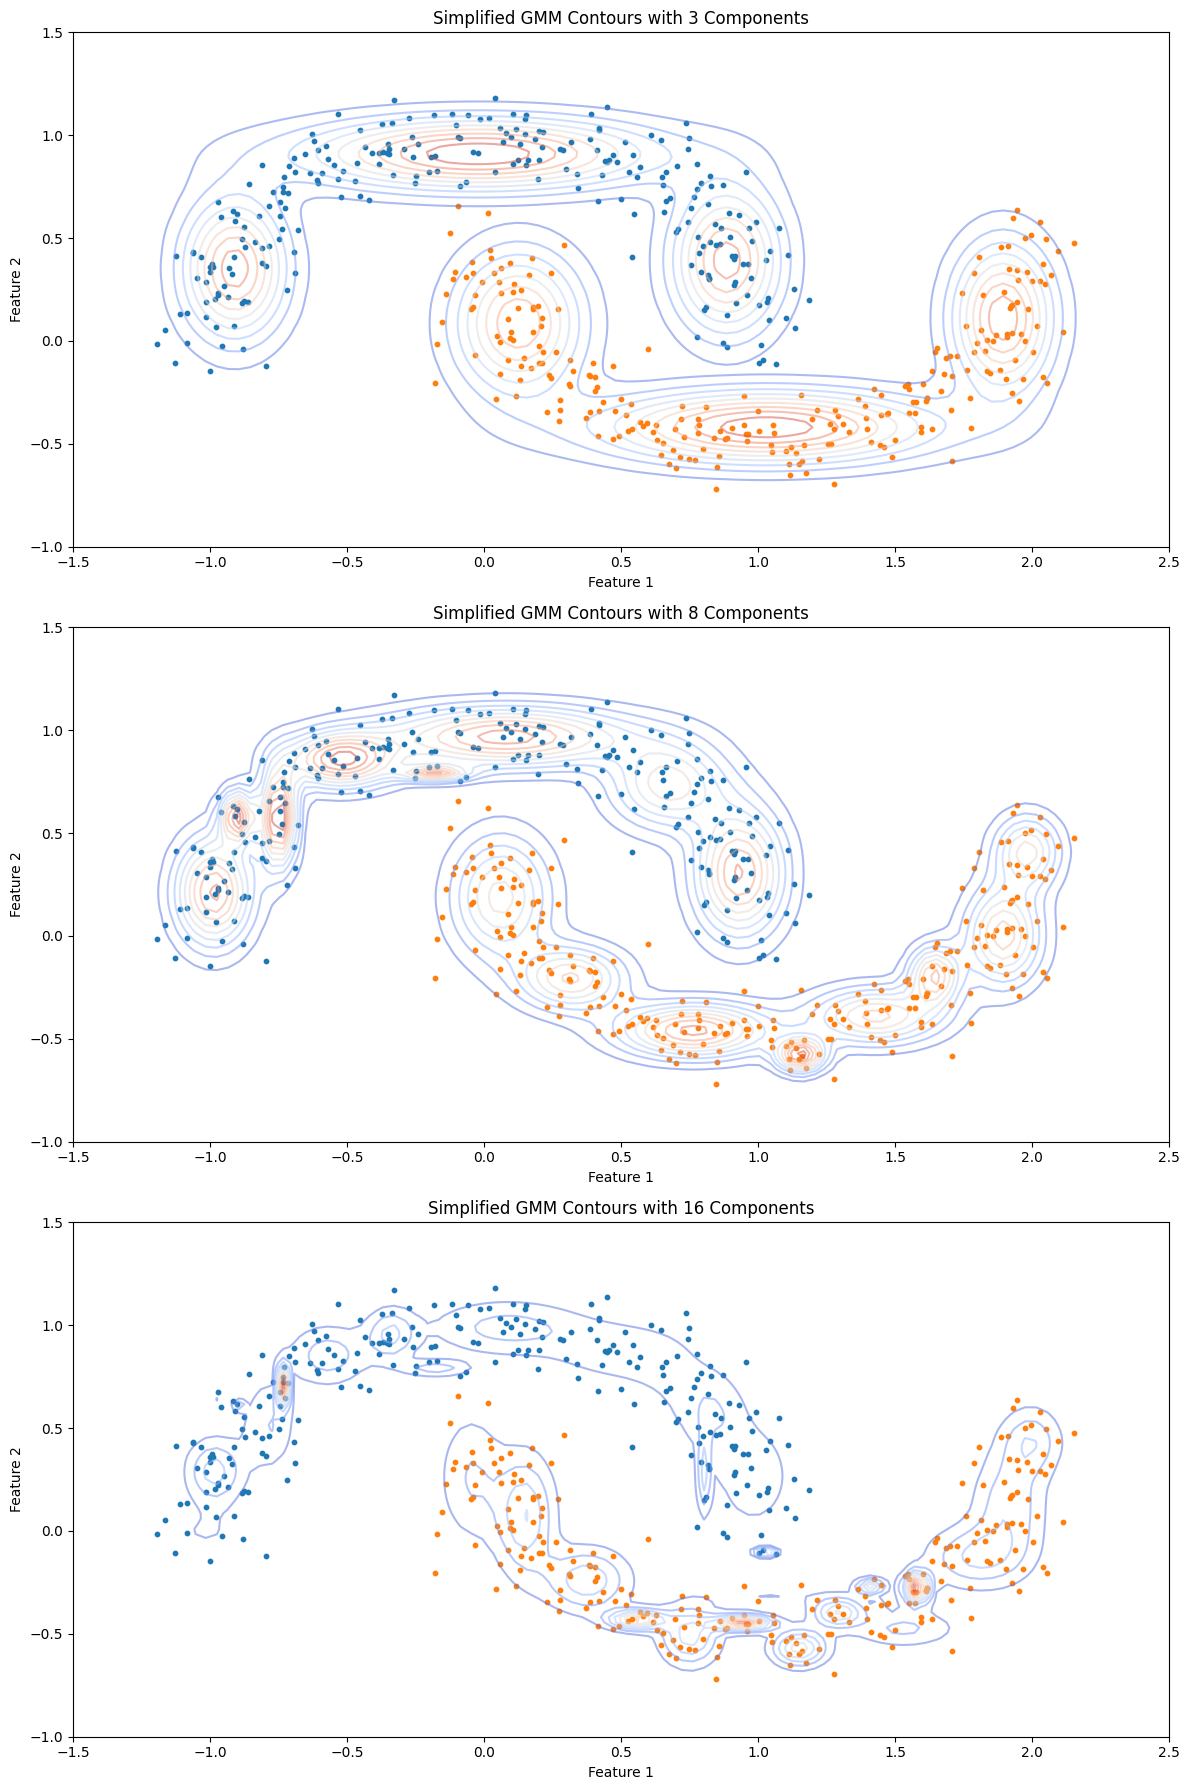

In [21]:
class SimplifiedGMMRegularized:
    def __init__(self, n_components, n_iter=100, reg_covar=1e-6):
        self.n_components = n_components
        self.n_iter = n_iter
        self.reg_covar = reg_covar
        self.means = None
        self.covs = None
        self.weights = None

    def fit(self, X):
        # Random initialization of parameters
        n_samples, n_features = X.shape
        self.means = np.random.rand(self.n_components, n_features)
        self.covs = np.random.rand(self.n_components, n_features)
        self.weights = np.random.rand(self.n_components)
        self.weights /= self.weights.sum()

        for _ in range(self.n_iter):
            # E-Step
            responsibilities = self._e_step(X)

            # M-Step
            self._m_step(X, responsibilities)

    def _e_step(self, X):
        # Calculate responsibilities
        resp = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            resp[:, k] = self.weights[k] * self._gaussian_pdf(X, self.means[k], np.diag(self.covs[k]))
        resp /= resp.sum(axis=1, keepdims=True)
        return resp

    def _m_step(self, X, resp):
        # Update parameters
        for k in range(self.n_components):
            Nk = resp[:, k].sum()
            self.means[k] = (X * resp[:, k, np.newaxis]).sum(axis=0) / Nk
            diff = X - self.means[k]
            self.covs[k] = (resp[:, k, np.newaxis] * diff**2).sum(axis=0) / Nk
            self.covs[k] += self.reg_covar  # Regularization to avoid singular covariance matrix
            self.weights[k] = Nk / X.shape[0]

    def _gaussian_pdf(self, X, mean, cov):
        # Calculate the Gaussian probability density function
        n = mean.shape[0]
        diff = X - mean
        return np.exp(-0.5 * np.sum(diff @ np.linalg.inv(cov) * diff, axis=1)) / \
               ((2 * np.pi)**(n/2) * np.sqrt(np.linalg.det(cov)))

def plot_gmm_contours(ax,gmm, X, title):
    x, y = np.linspace(-1.5, 2.5, 100), np.linspace(-1, 1.5, 100)
    Xgrid, Ygrid = np.meshgrid(x, y)
    XX = np.array([Xgrid.ravel(), Ygrid.ravel()]).T

    Z = np.zeros((XX.shape[0], gmm.n_components))
    for k in range(gmm.n_components):
        Z[:, k] = gmm.weights[k] * gmm._gaussian_pdf(XX, gmm.means[k], np.diag(gmm.covs[k]))
    Z = Z.sum(axis=1).reshape(Xgrid.shape)


    ax.contour(Xgrid, Ygrid, Z, levels=10, cmap='coolwarm', alpha=0.5)
    ax.scatter(X[:, 0], X[:, 1], s=10)
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    return fig
fig, axs = plt.subplots(3, figsize=(12, 18))

# Applying the Simplified GMM for 3, 8, and 16 components
for i, n_components in enumerate([3, 8, 16]):
    gmm_reg = SimplifiedGMMRegularized(n_components)
    gmm_reg.fit(class_0)
    plot_gmm_contours(axs[i], gmm_reg, class_0, f'Simplified GMM Contours with {n_components} Components')

    gmm_reg = SimplifiedGMMRegularized(n_components)
    gmm_reg.fit(class_1)
    plot_gmm_contours(axs[i], gmm_reg, class_1, f'Simplified GMM Contours with {n_components} Components')

plt.tight_layout()
plt.show()


Optimal number of components based on AIC for Class zero: 4
Optimal number of components based on BIC for Class zero: 3
Optimal number of components based on AIC for Class one: 4
Optimal number of components based on BIC for Class one: 4


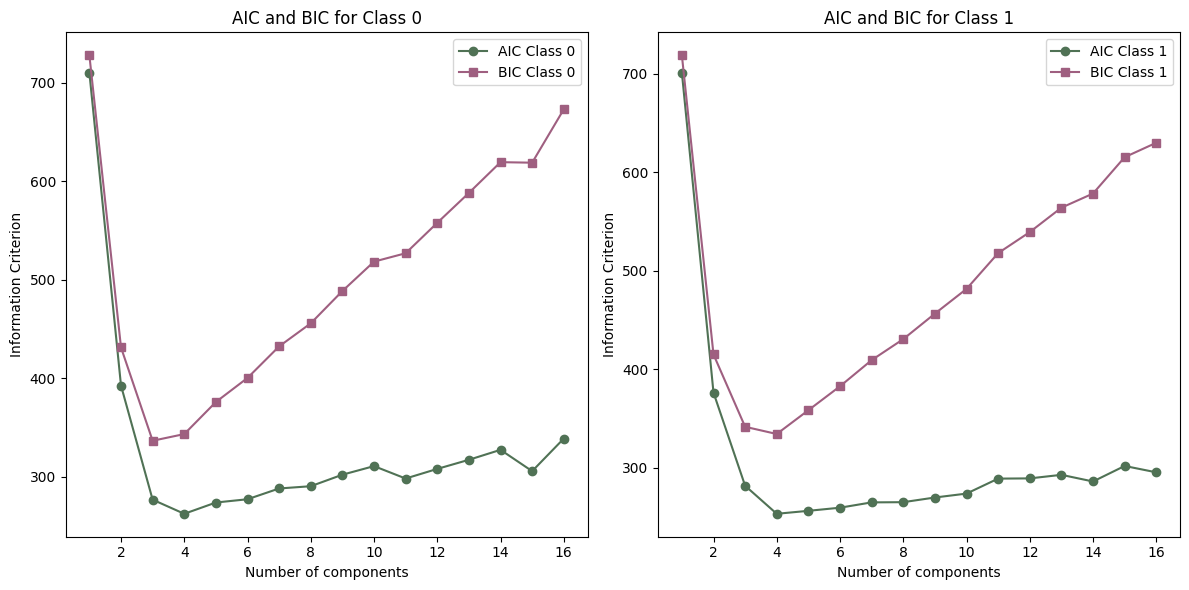

In [7]:
from sklearn.mixture import GaussianMixture
# Define the range of components to be tested
n_components_range = range(1, 17)
aic_class_0, bic_class_0 = [], []
aic_class_1, bic_class_1 = [], []

# Fit GMMs and compute AIC and BIC for each number of components
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, max_iter=100, reg_covar=1e-6)

    # Fit to class 0
    gmm.fit(class_0)
    aic_class_0.append(gmm.aic(class_0))
    bic_class_0.append(gmm.bic(class_0))

    # Fit to class 1
    gmm.fit(class_1)
    aic_class_1.append(gmm.aic(class_1))
    bic_class_1.append(gmm.bic(class_1))


# Find the optimal number of components based on AIC and BIC
optimal_aic_components_0 = n_components_range[np.argmin(aic_class_0)]
optimal_bic_components_0 = n_components_range[np.argmin(bic_class_0)]

optimal_aic_components_1 = n_components_range[np.argmin(aic_class_1)]
optimal_bic_components_1 = n_components_range[np.argmin(bic_class_1)]

print(f'Optimal number of components based on AIC for Class zero: {optimal_aic_components_0}')
print(f'Optimal number of components based on BIC for Class zero: {optimal_bic_components_0}')

print(f'Optimal number of components based on AIC for Class one: {optimal_aic_components_1}')
print(f'Optimal number of components based on BIC for Class one: {optimal_bic_components_1}')

# Plotting AIC and BIC
plt.figure(figsize=(12, 6))

# AIC and BIC for class 0
plt.subplot(1, 2, 1)
plt.plot(n_components_range, aic_class_0, label='AIC Class 0', color = '#507255', marker='o')
plt.plot(n_components_range, bic_class_0, label='BIC Class 0', marker='s' ,color = '#9F5F80')
plt.xlabel('Number of components')
plt.ylabel('Information Criterion')
plt.title('AIC and BIC for Class 0')
plt.legend()

# AIC and BIC for class 1
plt.subplot(1, 2, 2)
plt.plot(n_components_range, aic_class_1, label='AIC Class 1',  color = '#507255', marker='o')
plt.plot(n_components_range, bic_class_1, label='BIC Class 1', marker='s' , color = '#9F5F80' )
plt.xlabel('Number of components')
plt.ylabel('Information Criterion')
plt.title('AIC and BIC for Class 1')
plt.legend()

plt.tight_layout()
plt.show()

